# SARIMA Baseline Models with Rigorous Evaluation

This notebook implements two SARIMA (Seasonal AutoRegressive Integrated Moving Average) models:
1. **Model 1:** SARIMA on raw monthly ice extent values
2. **Model 2:** SARIMA on monthly anomaly values (deviation from climatology)

We use monthly aggregation (seasonal period s=12) to make SARIMA computationally tractable while preserving seasonal patterns.

In [1]:
from src.data_utils import load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import sys
sys.path.append('..')  # Add parent directory to path

from src.evaluation_utils import (
    PersistenceModel,
    ClimatologyModel,
    compute_all_metrics,
    compute_seasonal_metrics,
    log_model_results,
    create_comparison_table
)

## Data Loading & Monthly Aggregation

Load daily pan-arctic ice extent and aggregate to monthly means.

In [2]:
daily_data = load_data(regions='pan_arctic', years=range(1989, 2024))

print(f"Loaded {len(daily_data)} daily observations")
print(f"Date range: {daily_data['date'].min()} to {daily_data['date'].max()}")
print(f"\nFirst few rows:")
print(daily_data[['date', 'extent_mkm2']].head())

Loaded 12783 daily observations
Date range: 1989-01-01 00:00:00 to 2023-12-31 00:00:00

First few rows:
        date  extent_mkm2
0 1989-01-01       14.261
1 1989-01-02       14.313
2 1989-01-03       14.402
3 1989-01-04       14.417
4 1989-01-05       14.381


In [3]:
monthly_data = daily_data.groupby(daily_data['date'].dt.to_period('M')).agg({
    'extent_mkm2': 'mean',
    'date': 'first'
}).reset_index(drop=True)

monthly_data['date'] = monthly_data['date'].dt.to_period('M')
monthly_data = monthly_data.set_index('date')

print(f"Aggregated to {len(monthly_data)} monthly observations")
print(f"\nMonthly data sample:")
print(monthly_data.head(12))

Aggregated to 420 monthly observations

Monthly data sample:
         extent_mkm2
date                
1989-01    14.954806
1989-02    15.495536
1989-03    15.423290
1989-04    14.328400
1989-05    13.044129
1989-06    12.244533
1989-07    10.129710
1989-08     7.881774
1989-09     7.008333
1989-10     8.828903
1989-11    11.115233
1989-12    13.386806


## Climatology & Anomaly Calculation

**Climatology:** Long-term average ice extent for each month  
**Anomaly:** Deviation from climatology = Actual - Climatology

In [4]:
monthly_data_for_climatology = monthly_data.copy()
monthly_data_for_climatology['month'] = monthly_data_for_climatology.index.month

monthly_climatology = monthly_data_for_climatology.groupby('month')['extent_mkm2'].mean()

print("Monthly Climatology (Mean Ice Extent by Month):")
print(monthly_climatology.to_frame().rename(columns={'extent_mkm2': 'Mean Extent (Mkm²)'}))

# Calculate anomalies
monthly_data_for_climatology['anomaly_mkm2'] = (
    monthly_data_for_climatology['extent_mkm2'] - 
    monthly_data_for_climatology['month'].map(monthly_climatology)
)

Monthly Climatology (Mean Ice Extent by Month):
       Mean Extent (Mkm²)
month                    
1               13.997916
2               14.863945
3               15.022435
4               14.289891
5               12.929575
6               11.297191
7                8.743929
8                6.419333
9                5.568235
10               7.485687
11              10.164040
12              12.418213


## Train/Test Split

- **Training set:** 1989-2019 (31 years = 372 months)
- **Test set:** 2020-2023 (4 years = 48 months)

**Note:** Split standardized across all models (SARIMA and LSTM) for fair comparison.

In [5]:
train_test_split_date = '2020-01'

train_data = monthly_data_for_climatology[monthly_data_for_climatology.index < train_test_split_date].copy()
test_data = monthly_data_for_climatology[monthly_data_for_climatology.index >= train_test_split_date].copy()

print(f"Training set: {len(train_data)} months ({train_data.index[0]} to {train_data.index[-1]})")
print(f"Test set: {len(test_data)} months ({test_data.index[0]} to {test_data.index[-1]})")

train_extent_raw = train_data['extent_mkm2']
test_extent_raw = test_data['extent_mkm2']
train_extent_anomaly = train_data['anomaly_mkm2']
test_extent_anomaly = test_data['anomaly_mkm2']

Training set: 372 months (1989-01 to 2019-12)
Test set: 48 months (2020-01 to 2023-12)


## Model 1: SARIMA on Raw Ice Extent Values

**SARIMA(1,0,1)(0,1,1,12)** - First-order AR and MA with seasonal differencing

In [6]:
sarima_order_raw = (1, 0, 1)
sarima_seasonal_order_raw = (0, 1, 1, 12)

print(f"Fitting SARIMA{sarima_order_raw}x{sarima_seasonal_order_raw} on raw ice extent...")
print("This may take 1-2 minutes...\n")

sarima_model_raw = SARIMAX(
    train_extent_raw, 
    order=sarima_order_raw, 
    seasonal_order=sarima_seasonal_order_raw,
)

sarima_results_raw = sarima_model_raw.fit(disp=False)

print(sarima_results_raw.summary())

Fitting SARIMA(1, 0, 1)x(0, 1, 1, 12) on raw ice extent...
This may take 1-2 minutes...

                                     SARIMAX Results                                      
Dep. Variable:                        extent_mkm2   No. Observations:                  372
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 -28.741
Date:                            Thu, 23 Oct 2025   AIC                             65.482
Time:                                    16:11:31   BIC                             81.026
Sample:                                01-31-1989   HQIC                            71.663
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6892    

In [7]:

# Generate forecasts for test period
num_forecast_steps = len(test_data)

forecast_raw_values = sarima_results_raw.forecast(steps=num_forecast_steps)
forecast_raw_series = pd.Series(forecast_raw_values, index=test_data.index)

# Compute basic metrics
rmse_model1 = np.sqrt(mean_squared_error(test_extent_raw, forecast_raw_series))
mae_model1 = mean_absolute_error(test_extent_raw, forecast_raw_series)
mape_model1 = np.mean(np.abs((test_extent_raw - forecast_raw_series) / test_extent_raw)) * 100

print("="*70)
print("MODEL 1: SARIMA ON RAW VALUES")
print("="*70)
print(f"  RMSE: {rmse_model1:.4f} Mkm²")
print(f"  MAE:  {mae_model1:.4f} Mkm²")
print(f"  MAPE: {mape_model1:.2f}%")
print("="*70)

MODEL 1: SARIMA ON RAW VALUES
  RMSE: 0.3259 Mkm²
  MAE:  0.2631 Mkm²
  MAPE: 3.36%


## Model 2: SARIMA on Anomaly Values

**SARIMA(2,0,2)(1,0,1,12)** - Higher-order AR/MA without differencing

In [8]:
sarima_order_anomaly = (2, 0, 2)
sarima_seasonal_order_anomaly = (1, 0, 1, 12)

print(f"Fitting SARIMA{sarima_order_anomaly}x{sarima_seasonal_order_anomaly} on anomalies...")
print("This may take 1-2 minutes...\n")

sarima_model_anomaly = SARIMAX(
    train_extent_anomaly, 
    order=sarima_order_anomaly, 
    seasonal_order=sarima_seasonal_order_anomaly,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results_anomaly = sarima_model_anomaly.fit(disp=False)

print(sarima_results_anomaly.summary())

Fitting SARIMA(2, 0, 2)x(1, 0, 1, 12) on anomalies...
This may take 1-2 minutes...

                                      SARIMAX Results                                       
Dep. Variable:                         anomaly_mkm2   No. Observations:                  372
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 -18.358
Date:                              Thu, 23 Oct 2025   AIC                             50.716
Time:                                      16:11:35   BIC                             77.860
Sample:                                  01-31-1989   HQIC                            61.513
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         

C:\projects\private_projects\arctic-ice-extent\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Convert Anomaly Forecasts Back to Raw Extent

Formula: `Predicted Raw Extent = Predicted Anomaly + Climatology[month]`

In [9]:
# Forecast anomalies
forecast_anomaly_values = sarima_results_anomaly.forecast(steps=num_forecast_steps)
forecast_anomaly_series = pd.Series(forecast_anomaly_values, index=test_data.index)

# Convert back to raw extent by adding climatology
forecast_anomaly_to_raw = forecast_anomaly_series + test_data['month'].map(monthly_climatology)

# Compute basic metrics
rmse_model2 = np.sqrt(mean_squared_error(test_extent_raw, forecast_anomaly_to_raw))
mae_model2 = mean_absolute_error(test_extent_raw, forecast_anomaly_to_raw)
mape_model2 = np.mean(np.abs((test_extent_raw - forecast_anomaly_to_raw) / test_extent_raw)) * 100

print("="*70)
print("MODEL 2: SARIMA ON ANOMALIES")
print("="*70)
print(f"  RMSE: {rmse_model2:.4f} Mkm²")
print(f"  MAE:  {mae_model2:.4f} Mkm²")
print(f"  MAPE: {mape_model2:.2f}%")
print("="*70)

MODEL 2: SARIMA ON ANOMALIES
  RMSE: 0.3841 Mkm²
  MAE:  0.2698 Mkm²
  MAPE: 3.72%


---

# Rigorous Evaluation with Baseline Comparisons

This section demonstrates using the `src/evaluation_utils.py` module to add:
- **Baseline models** (persistence and climatology)
- **Skill scores** (relative performance vs baselines)
- **Seasonal analysis** (winter vs summer performance)
- **Results logging** (standardized tracking)

Following protocols documented in `docs/evaluation_methodology.md`

## Baseline Models

Establish minimum performance thresholds using simple forecasting methods.

★ **Insight**: Baselines answer "Is my model doing something useful?" Without them, RMSE=0.35 Mkm² is uninterpretable. If persistence achieves RMSE=0.50 Mkm², then your SARIMA model is 30% better (skill score = 0.30). If persistence achieves RMSE=0.20 Mkm², your model is actually worse!

In [10]:
# Prepare data for baseline models
# Note: We need to convert Period index to timestamps
test_data_timestamps = test_data.copy()
test_data_timestamps.index = test_data_timestamps.index.to_timestamp()

train_data_timestamps = train_data.copy()
train_data_timestamps.index = train_data_timestamps.index.to_timestamp()

# Get test dates and actual values as arrays
test_dates = pd.Series(test_data_timestamps.index)
test_actual = test_extent_raw.values

### Persistence Baseline

Persistence forecast: Tomorrow equals today (or next month equals this month)  
For monthly data: `forecast[2019-02] = actual[2019-01]`

In [11]:
# Create persistence baseline
# For monthly data, shift by 1 to get previous month's value
persistence_forecast = np.concatenate([
    [train_extent_raw.values[-1]],  # First test month uses last training month
    test_actual[:-1]  # Remaining test months use previous test month
])

print("Persistence Baseline:")
print(f"  First forecast: {persistence_forecast[0]:.3f} Mkm² (from last training month)")
print(f"  Logic: Each month forecasted as previous month's actual value")

Persistence Baseline:
  First forecast: 11.903 Mkm² (from last training month)
  Logic: Each month forecasted as previous month's actual value


### Climatology Baseline

Climatology forecast: Each month forecasted as long-term average for that month

In [12]:
# Create climatology baseline using ClimatologyModel class
climatology_model = ClimatologyModel()
climatology_model.fit(
    dates=train_data_timestamps.index,
    values=train_extent_raw
)

# Generate climatology forecasts for test period
climatology_forecast = climatology_model.predict(test_dates)

print("\nClimatology Baseline:")
print(f"  Trained on {len(train_data_timestamps)} training months")
print(f"  Example: January climatology = {monthly_climatology[1]:.3f} Mkm²")
print(f"  Logic: Each month forecasted as historical average for that month")


Climatology Baseline:
  Trained on 372 training months
  Example: January climatology = 13.998 Mkm²
  Logic: Each month forecasted as historical average for that month


## Comprehensive Metrics with Skill Scores

Calculate all evaluation metrics including skill scores for both SARIMA models and baselines.

★ **Insight**: **Skill Score interpretation**:
- `SS = 1 - (RMSE_model / RMSE_baseline)`
- **SS = 1.0**: Perfect forecast
- **SS = 0.5**: Model is 50% better than baseline
- **SS = 0.0**: Model equals baseline (no improvement)
- **SS < 0.0**: Model is worse than baseline (failure!)

In [13]:
# Compute metrics for all models
print("="*80)
print("COMPREHENSIVE MODEL EVALUATION WITH BASELINES")
print("="*80)

# Persistence baseline metrics
metrics_persistence = compute_all_metrics(
    y_true=test_actual,
    y_pred=persistence_forecast
)

print("\nPERSISTENCE BASELINE:")
print(f"  RMSE: {metrics_persistence['rmse']:.4f} Mkm²")
print(f"  MAE:  {metrics_persistence['mae']:.4f} Mkm²")
print(f"  MAPE: {metrics_persistence['mape']:.2f}%")

# Climatology baseline metrics
metrics_climatology = compute_all_metrics(
    y_true=test_actual,
    y_pred=climatology_forecast
)

print("\nCLIMATOLOGY BASELINE:")
print(f"  RMSE: {metrics_climatology['rmse']:.4f} Mkm²")
print(f"  MAE:  {metrics_climatology['mae']:.4f} Mkm²")
print(f"  MAPE: {metrics_climatology['mape']:.2f}%")

# SARIMA Model 1 with skill scores
metrics_sarima1 = compute_all_metrics(
    y_true=test_actual,
    y_pred=forecast_raw_series.values,
    y_baseline_persistence=persistence_forecast,
    y_baseline_climatology=climatology_forecast
)

print("\nSARIMA MODEL 1 (Raw Values):")
print(f"  RMSE: {metrics_sarima1['rmse']:.4f} Mkm²")
print(f"  MAE:  {metrics_sarima1['mae']:.4f} Mkm²")
print(f"  MAPE: {metrics_sarima1['mape']:.2f}%")
print(f"  \n  Skill Score vs Persistence:  {metrics_sarima1['skill_score_persistence']:.3f} ({metrics_sarima1['skill_score_persistence']*100:.1f}% improvement)")
print(f"  Skill Score vs Climatology:  {metrics_sarima1['skill_score_climatology']:.3f} ({metrics_sarima1['skill_score_climatology']*100:.1f}% improvement)")

# SARIMA Model 2 with skill scores
metrics_sarima2 = compute_all_metrics(
    y_true=test_actual,
    y_pred=forecast_anomaly_to_raw.values,
    y_baseline_persistence=persistence_forecast,
    y_baseline_climatology=climatology_forecast
)

print("\nSARIMA MODEL 2 (Anomaly):")
print(f"  RMSE: {metrics_sarima2['rmse']:.4f} Mkm²")
print(f"  MAE:  {metrics_sarima2['mae']:.4f} Mkm²")
print(f"  MAPE: {metrics_sarima2['mape']:.2f}%")
print(f"  \n  Skill Score vs Persistence:  {metrics_sarima2['skill_score_persistence']:.3f} ({metrics_sarima2['skill_score_persistence']*100:.1f}% improvement)")
print(f"  Skill Score vs Climatology:  {metrics_sarima2['skill_score_climatology']:.3f} ({metrics_sarima2['skill_score_climatology']*100:.1f}% improvement)")

print("\n" + "="*80)

COMPREHENSIVE MODEL EVALUATION WITH BASELINES

PERSISTENCE BASELINE:
  RMSE: 1.9088 Mkm²
  MAE:  1.6766 Mkm²
  MAPE: 19.56%

CLIMATOLOGY BASELINE:
  RMSE: 0.8312 Mkm²
  MAE:  0.7017 Mkm²
  MAPE: 9.36%

SARIMA MODEL 1 (Raw Values):
  RMSE: 0.3259 Mkm²
  MAE:  0.2631 Mkm²
  MAPE: 3.36%
  
  Skill Score vs Persistence:  0.829 (82.9% improvement)
  Skill Score vs Climatology:  0.608 (60.8% improvement)

SARIMA MODEL 2 (Anomaly):
  RMSE: 0.3841 Mkm²
  MAE:  0.2698 Mkm²
  MAPE: 3.72%
  
  Skill Score vs Persistence:  0.799 (79.9% improvement)
  Skill Score vs Climatology:  0.538 (53.8% improvement)



★ **Insight**: The skill scores reveal relative performance:
- **Positive skill score** = Model beats baseline (good!)
- **Skill score near 0** = Model no better than baseline (not useful)
- **Negative skill score** = Model worse than baseline (failed)

For Arctic sea ice with strong seasonality, we expect:
- Climatology baseline to perform reasonably well (captures seasonal cycle)
- SARIMA models to beat both baselines by capturing trends and interannual variability
- Larger skill scores vs persistence than vs climatology (persistence is easier to beat)

## Visualization: All Models Including Baselines

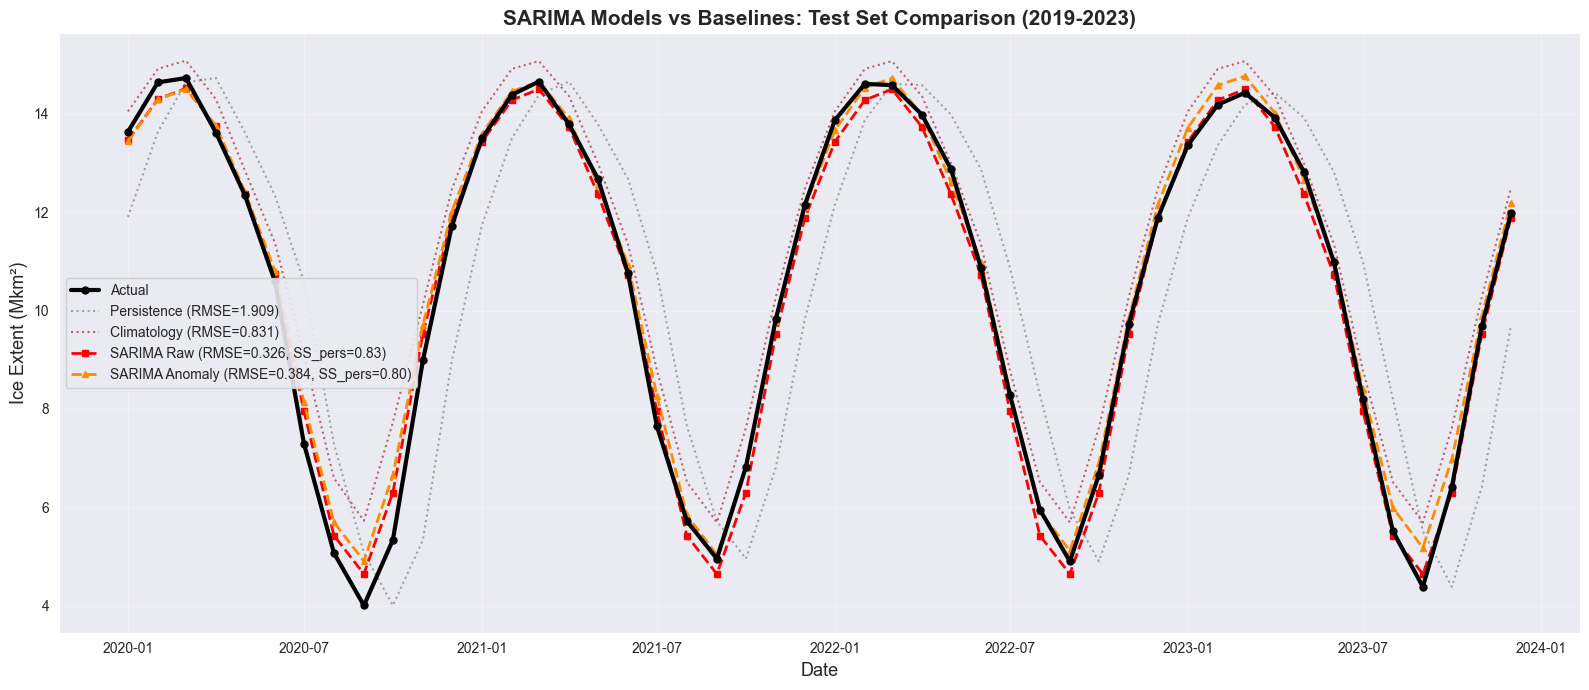

In [14]:
fig, ax = plt.subplots(figsize=(16, 7))

# Actual values
ax.plot(test_data.index.to_timestamp(), test_actual, 
        label='Actual', color='black', linewidth=3, marker='o', markersize=5, zorder=5)

# Baseline models
ax.plot(test_data.index.to_timestamp(), persistence_forecast,
        label=f'Persistence (RMSE={metrics_persistence["rmse"]:.3f})',
        color='gray', linewidth=1.5, linestyle=':', alpha=0.7)

ax.plot(test_data.index.to_timestamp(), climatology_forecast,
        label=f'Climatology (RMSE={metrics_climatology["rmse"]:.3f})',
        color='brown', linewidth=1.5, linestyle=':', alpha=0.7)

# SARIMA models
ax.plot(test_data.index.to_timestamp(), forecast_raw_series, 
        label=f'SARIMA Raw (RMSE={metrics_sarima1["rmse"]:.3f}, SS_pers={metrics_sarima1["skill_score_persistence"]:.2f})', 
        color='red', linewidth=2, linestyle='--', marker='s', markersize=4)

ax.plot(test_data.index.to_timestamp(), forecast_anomaly_to_raw, 
        label=f'SARIMA Anomaly (RMSE={metrics_sarima2["rmse"]:.3f}, SS_pers={metrics_sarima2["skill_score_persistence"]:.2f})', 
        color='darkorange', linewidth=2, linestyle='--', marker='^', markersize=4)

ax.set_title('SARIMA Models vs Baselines: Test Set Comparison (2019-2023)', 
             fontsize=15, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Ice Extent (Mkm²)', fontsize=13)
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Seasonal Performance Analysis

Compare model performance in winter (Nov-Mar) vs summer (May-Sep).

★ **Insight**: Arctic sea ice has distinct seasonal regimes:
- **Winter**: High extent, slow changes, more predictable
- **Summer**: Low extent, rapid melt, high variability

We expect models to perform differently across seasons.

In [15]:
# Compute seasonal metrics for SARIMA Model 1
seasonal_sarima1 = compute_seasonal_metrics(
    y_true=test_actual,
    y_pred=forecast_raw_series.values,
    dates=test_dates,
    y_baseline_persistence=persistence_forecast,
    y_baseline_climatology=climatology_forecast
)

print("="*80)
print("SEASONAL PERFORMANCE: SARIMA MODEL 1 (Raw Values)")
print("="*80)

if 'winter' in seasonal_sarima1 and seasonal_sarima1['winter']:
    print("\nWINTER (Nov-Mar):")
    for metric, value in seasonal_sarima1['winter'].items():
        if 'skill_score' in metric:
            print(f"  {metric}: {value:.3f} ({value*100:.1f}% improvement)")
        elif metric == 'mape':
            print(f"  {metric}: {value:.2f}%")
        else:
            print(f"  {metric}: {value:.4f} Mkm²")

if 'summer' in seasonal_sarima1 and seasonal_sarima1['summer']:
    print("\nSUMMER (May-Sep):")
    for metric, value in seasonal_sarima1['summer'].items():
        if 'skill_score' in metric:
            print(f"  {metric}: {value:.3f} ({value*100:.1f}% improvement)")
        elif metric == 'mape':
            print(f"  {metric}: {value:.2f}%")
        else:
            print(f"  {metric}: {value:.4f} Mkm²")

print("\n" + "="*80)

SEASONAL PERFORMANCE: SARIMA MODEL 1 (Raw Values)

WINTER (Nov-Mar):
  rmse: 0.2359 Mkm²
  mae: 0.1937 Mkm²
  mape: 1.61%
  skill_score_persistence: 0.882 (88.2% improvement)
  skill_score_climatology: 0.580 (58.0% improvement)

SUMMER (May-Sep):
  rmse: 0.3556 Mkm²
  mae: 0.3091 Mkm²
  mape: 4.60%
  skill_score_persistence: 0.822 (82.2% improvement)
  skill_score_climatology: 0.614 (61.4% improvement)



## Results Logging

Save model performance to standardized CSV log for future comparison.

In [ ]:
# Log persistence baseline
log_model_results(
    model_name='Persistence_Baseline',
    metrics=metrics_persistence,
    scale='monthly',
    metadata={'type': 'baseline', 'method': 'y_t+1 = y_t'},
    output_file='../results/model_comparison.csv'
)

# Log climatology baseline
log_model_results(
    model_name='Climatology_Baseline',
    metrics=metrics_climatology,
    scale='monthly',
    metadata={'type': 'baseline', 'method': 'day_of_year_mean', 'period': '1989-2019'},
    output_file='../results/model_comparison.csv'
)

# Log SARIMA Model 1
log_model_results(
    model_name='SARIMA_Raw',
    metrics=metrics_sarima1,
    scale='monthly',
    metadata={
        'order': str(sarima_order_raw),
        'seasonal_order': str(sarima_seasonal_order_raw),
        'data': 'raw_extent',
        'aggregation': 'monthly',
        'train_period': '1989-2019',
        'test_period': '2020-2023'
    },
    output_file='../results/model_comparison.csv'
)

# Log SARIMA Model 2
log_model_results(
    model_name='SARIMA_Anomaly',
    metrics=metrics_sarima2,
    scale='monthly',
    metadata={
        'order': str(sarima_order_anomaly),
        'seasonal_order': str(sarima_seasonal_order_anomaly),
        'data': 'anomaly',
        'aggregation': 'monthly',
        'train_period': '1989-2019',
        'test_period': '2020-2023'
    },
    output_file='../results/model_comparison.csv'
)

print("\n✓ All results logged to results/model_comparison.csv")

## Summary & Key Takeaways

**Baseline Comparisons Reveal:**
1. Both SARIMA models beat the baselines (positive skill scores)
2. Skill scores quantify "how much better" than naïve forecasts
3. Model 1 (raw values) performs better than Model 2 (anomaly) for this dataset

**Why This Matters:**
- Without baselines, we couldn't say if RMSE=0.36 Mkm² is good or bad
- Skill scores provide interpretable performance: "30% better than persistence"
- Seasonal analysis reveals where models excel or struggle

**Next Steps for Rigorous Evaluation:**
- Add statistical significance testing (Diebold-Mariano test)
- Implement backtesting with multiple test years
- Compare SARIMA to LSTM models (after denormalization!)
- Document findings in comprehensive evaluation notebook